# 导入必要的库

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
import time
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [21]:
import torch.nn.functional as F

In [5]:
import torch.optim as optim

# 数据预处理

In [6]:
# 数据预处理，相当于提前定义了怎么处理数据：
# 因为读入的数据为numpy格式，所以我们要先将其转换为tensor格式，
# 然后对其进行归一化，有三个通道需要归一化，而第一个为均值，第二个为标准差
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集
trainset = tv.datasets.CIFAR10(
    # root='/kaggle/input/cifar10-python',
    root='/pytorch/Data',
    train=True,
    download=False,
    transform=transform
)

# 迭代器
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=True,
    num_workers=16
)

# 测试集
testset = tv.datasets.CIFAR10(
    # root='/kaggle/input/cifar10-python',
    root='/pytorch/Data',
    train=False,
    download=False,
    transform=transform
)

# 迭代器
testloader = t.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=False,
    num_workers=16
)
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ship


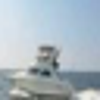

In [7]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

ship       truck       ship       horse       ship       ship       dog       dog       deer       dog       bird       bird       horse       cat       plane       frog       bird       dog       plane       truck       truck       frog       cat       dog       ship       car       cat       frog       dog       bird       truck       cat


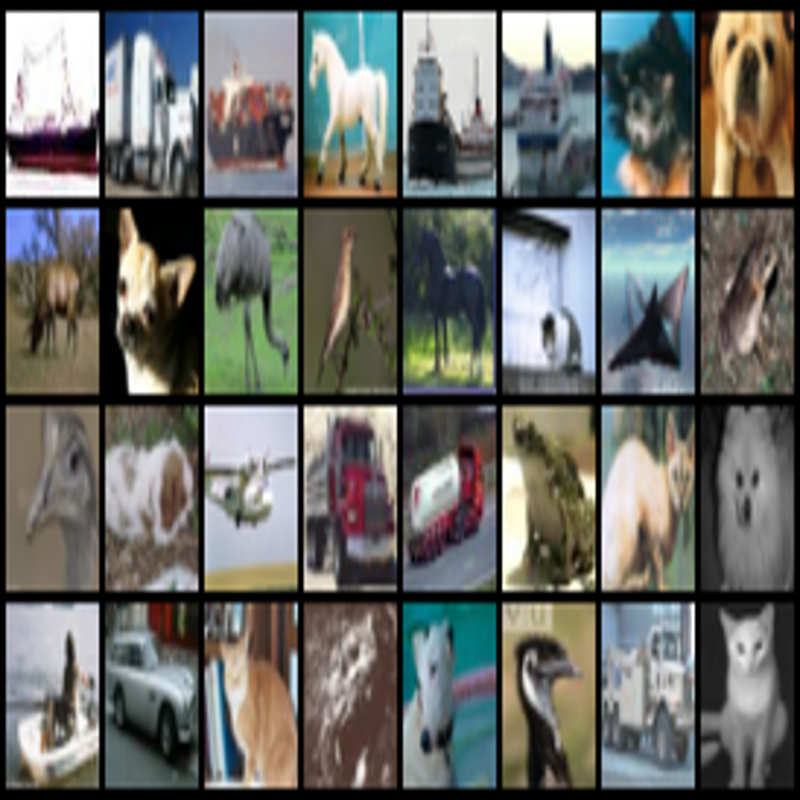

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('       '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((800, 800))

# 加载各个模型

## LeNet

In [9]:
# LeNet
class LeNet(nn.Module):
    
    def __init__(self) -> None:
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## AlexNet

In [10]:
# AlexNet
# AlexNet
NUM_CLASSES = 10

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # (32 + 1*2 - 3) / 2 + 1 = 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                        # (16 + 0 * 2 - 2) / 2  + 1 = 8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),    # (8 + 1 * 2 - 3) / 1 + 1 = 8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),    # (8 + 0 * 2 - 2) / 2 + 1 = 4
            nn.Conv2d(192, 384, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),    # (4 + 0 * 2 - 2) / 2 + 1 = 2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)   # 变换Tensor形状
        x = self.classifier(x)
        return x

alexnet = AlexNet()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

## VGG(11 13 16 19)

In [11]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')




In [12]:
vgg11, vgg13, vgg16, vgg19 = VGG11(), VGG13(),VGG16(), VGG19()
print(list(vgg11.parameters()))

[Parameter containing:
tensor([[[[-0.0808, -0.0070, -0.1893],
          [ 0.0597, -0.0651,  0.0966],
          [ 0.0457,  0.1852, -0.1671]],

         [[-0.0024,  0.0541,  0.0078],
          [-0.0203,  0.1099,  0.0649],
          [-0.1089,  0.0945,  0.0232]],

         [[ 0.0471, -0.1827, -0.1569],
          [-0.0987,  0.0312, -0.0243],
          [-0.1154,  0.0755,  0.0906]]],


        [[[-0.0443, -0.0772, -0.0423],
          [-0.1693, -0.1611,  0.1241],
          [-0.0004, -0.1080,  0.1077]],

         [[-0.0803, -0.0644,  0.0824],
          [-0.1749, -0.1864,  0.0231],
          [-0.0231, -0.0641, -0.0926]],

         [[-0.1094,  0.0155, -0.0222],
          [ 0.1068, -0.0082,  0.1088],
          [ 0.1738, -0.0209,  0.0622]]],


        [[[-0.1130, -0.0479,  0.0986],
          [ 0.0386,  0.0568, -0.1092],
          [ 0.1013,  0.0169,  0.0514]],

         [[ 0.0727, -0.1283, -0.0755],
          [ 0.1445, -0.0913,  0.1206],
          [-0.0547, -0.0383,  0.0786]],

         [[-0.0067, -

## GoogLeNet

In [13]:
# GoogLeNet
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return t.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [14]:
googlenet = GoogLeNet()

# 定义优化器和损失函数

In [15]:
# 定义优化器和损失函数
# optimizer = optim.Adam  # 这个到训练时再定义。
criterion = nn.CrossEntropyLoss()

*注意此时的optimizer没有参数*

# 加载到GPU上

In [16]:
# move the input and model to GPU for speed if available
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [ ]:
print(device)

# 训练模型

## 形成各个模型的列表

In [17]:
# list_all = [lenet, alexnet, vgg11, vgg13, vgg16, vgg19, googlenet]
# list_all_name = ['LeNet', 'AlexNet', 'VGG11', 'VGG13', 'VGG16', 'VGG19', 'GoogLeNet']
list_all = [lenet]
list_all_name = ['LeNet']

In [18]:
for name, net in zip(list_all_name, list_all):
    print('model:',name , 'params:', len(list(net.parameters())))

model: LeNet params: 10


## 加载到GPU上

In [19]:
for net in list_all:
    net.to(device)

## 训练模型

In [ ]:
# 训练网络
all_time = {}   # 用来装每一个类别20次epoch分别花费的时间
all_loss = {}   # 用来装每一个类别20次epoch每次epoch的loss
sort_accuracy = {}# 用来装最后一次epoch后，也即训练完成后，10类物体每一类的模型测试准确率
accuracy = {}# 用来装每个模型，20次epoch每一次的测试集准确率

for net_name, net in zip(list_all_name, list_all):
    
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    all_time[net_name] = []   # 用来装每一个类别20次epoch分别花费的时间
    all_loss[net_name] = []  # 用来装每一个类别20次epoch每次epoch的loss
    sort_accuracy[net_name] = [] # 用来装最后一次epoch后，也即训练完成后，10类物体每一类的模型测试准确率
    accuracy[net_name] = []  # 用来装每个模型，20次epoch每一次的测试集准确率

    for epoch in range(20):   # loop over the dataset multiple times
        
        start_time = time.time()
        running_loss = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(inputs)
            loss = criterion(output, labels)
            running_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        
        # Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time[net_name].append(time_taken)

        # loss
        all_loss[net_name].append(np.mean(running_loss))

        #Testing Accuracy
        correct = 0
        total = 0
        with t.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = t.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy[net_name].append(correct / total)

        # Every Sort accuracy
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with t.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = t.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        sort_accuracy[net_name] = [class_correct[i] / class_total[i] for i in range(10)]

    
    print(f'Finished Training of {net_name}, time spent: {sum(all_time[net_name])}s, Testing Accuracy:{accuracy[net_name][-1]}')

In [ ]:
import numpy as np
a = [1, 2, 3, 4]
np.mean(a)

2.5

# 画图分析